# COVID-19 infection classifier
The aim of this project is to design a classifier to predict the propability of an individual being infected with SARS-CoV-2. The prediction is based on the following features:
1. Basic information:
    * Gender (male/female)
    * Age (≥60 years (true/false))
2. Symptoms:
    * Cough (true/false)
    * Fever (true/false)
    * Sore throat (true/false)
    * Shortness of breath (true/false)
    * Headache (true/false)
3. Other information:
    * Known contact with an individual confirmed to have COVID-19 (true/false)

All the cases included in this dataset were confirmed via qPCR tests, containing (true/false) information.

#### References:
 * [Yazeed Zoabi, Shira Deri-Rozov & Noam Shomron. Machine learning-based prediction of COVID-19 diagnosis based on symptoms](https://www.nature.com/articles/s41746-020-00372-6) ; DOI: 0.1038/s41746-020-00372-6
 * [Dataset availability](https://github.com/nshomron/covidpred)

#### Library import

In [698]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, cohen_kappa_score
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler

#### Data loading

In [699]:
df = pd.read_csv('covidpred-master/data/corona_tested_individuals_ver_0083.english.csv')
df = df[::-1] # inverted the order, so that test_date starts from the earliest

/usr/local/Cellar/jupyterlab/2.1.5/libexec/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [700]:
df.head()

test_date  cough  fever  sore_throat  shortness_of_breath  \
2742595  2020-03-11      0      1            0                    0   
2742594  2020-03-11      0      0            0                    0   
2742593  2020-03-11      0      0            0                    0   
2742592  2020-03-11      0      0            0                    0   
2742591  2020-03-11      0      0            0                    0   

         head_ache corona_result age_60_and_above  gender test_indication  
2742595          0      negative              NaN    male           Other  
2742594          0      negative              NaN  female           Other  
2742593          0         other              NaN    male           Other  
2742592          0      negative              NaN  female           Other  
2742591          0      negative              NaN  female           Other

In [701]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742596 entries, 2742595 to 0
Data columns (total 10 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   test_date            object
 1   cough                int64 
 2   fever                int64 
 3   sore_throat          int64 
 4   shortness_of_breath  int64 
 5   head_ache            int64 
 6   corona_result        object
 7   age_60_and_above     object
 8   gender               object
 9   test_indication      object
dtypes: int64(5), object(5)
memory usage: 209.2+ MB


#### Data preprocessing
* replace all `str` values of '0' and '1' with `bool`
* replace 1s and 0s `int` values with `bool` just for consistency in the data frame
* replace `str` values of 'positive' and 'negative' with their respective `bool` values
* drop rows `None` or 'other' which are too ambiguous.
* according to [https://data.gov.il](https://data.gov.il/dataset/covid-19/resource/3f5c975e-7196-454b-8c5b-ef85881f78db/download/-readme.pdf) people with `corona_test` 'other' were ambiguous and therefore deleted from the database
* based on the same resource `test_indication` received `bool` values instead of ambiguous 'other' and 'abroad' which did not indicate their point clearly. For the purpouse of this project, either a person was in contact with a confirmed case or not.
* `gender` assumes binary values, 0 for male and 1 for female

In [702]:
# just to make it consistent
df = df.replace('0', 0)
# df = df.replace(0, False)
df = df.replace('1', 1)
# df = df.replace(1, True)
df = df.replace('Yes', 1)
df = df.replace('No', 0)
df = df.replace('positive', 1)
df = df.replace('negative', 0)

# convert object test_date to datetime
# df['test_date'] = pd.to_datetime(df['test_date'])

# delete rows with np.NaN values since there is no symptom data
df = df.replace('None', np.NaN)
df = df.replace('other', np.NaN)
df.dropna(axis=0, inplace=True)

# either the person was in contact or was not
df = df.replace('Other', 0)
df = df.replace('Abroad', 0)
df = df.replace('Contact with confirmed', 1)

# gender
df = df.replace('male', 0)
df = df.replace('female', 1)

In [552]:
df.dtypes

test_date               object
cough                    int64
fever                    int64
sore_throat              int64
shortness_of_breath      int64
head_ache                int64
corona_result          float64
age_60_and_above       float64
gender                   int64
test_indication          int64
dtype: object

In [703]:
X = df.drop(['test_date'], axis=1).drop(['corona_result'], axis=1)
y = df['corona_result']

In [704]:
X.head()

cough  fever  sore_throat  shortness_of_breath  head_ache  \
2731647      0      0            0                    0          0   
2731644      0      0            0                    0          0   
2731643      1      0            0                    0          0   
2731640      0      0            0                    0          0   
2731639      1      1            1                    1          1   

         age_60_and_above  gender  test_indication  
2731647               0.0       1                0  
2731644               0.0       1                0  
2731643               0.0       0                1  
2731640               0.0       1                0  
2731639               0.0       1                1

In [360]:
y.head()

2731647    False
2731644    False
2731643    False
2731640    False
2731639     True
Name: corona_result, dtype: bool

#### Show data plots

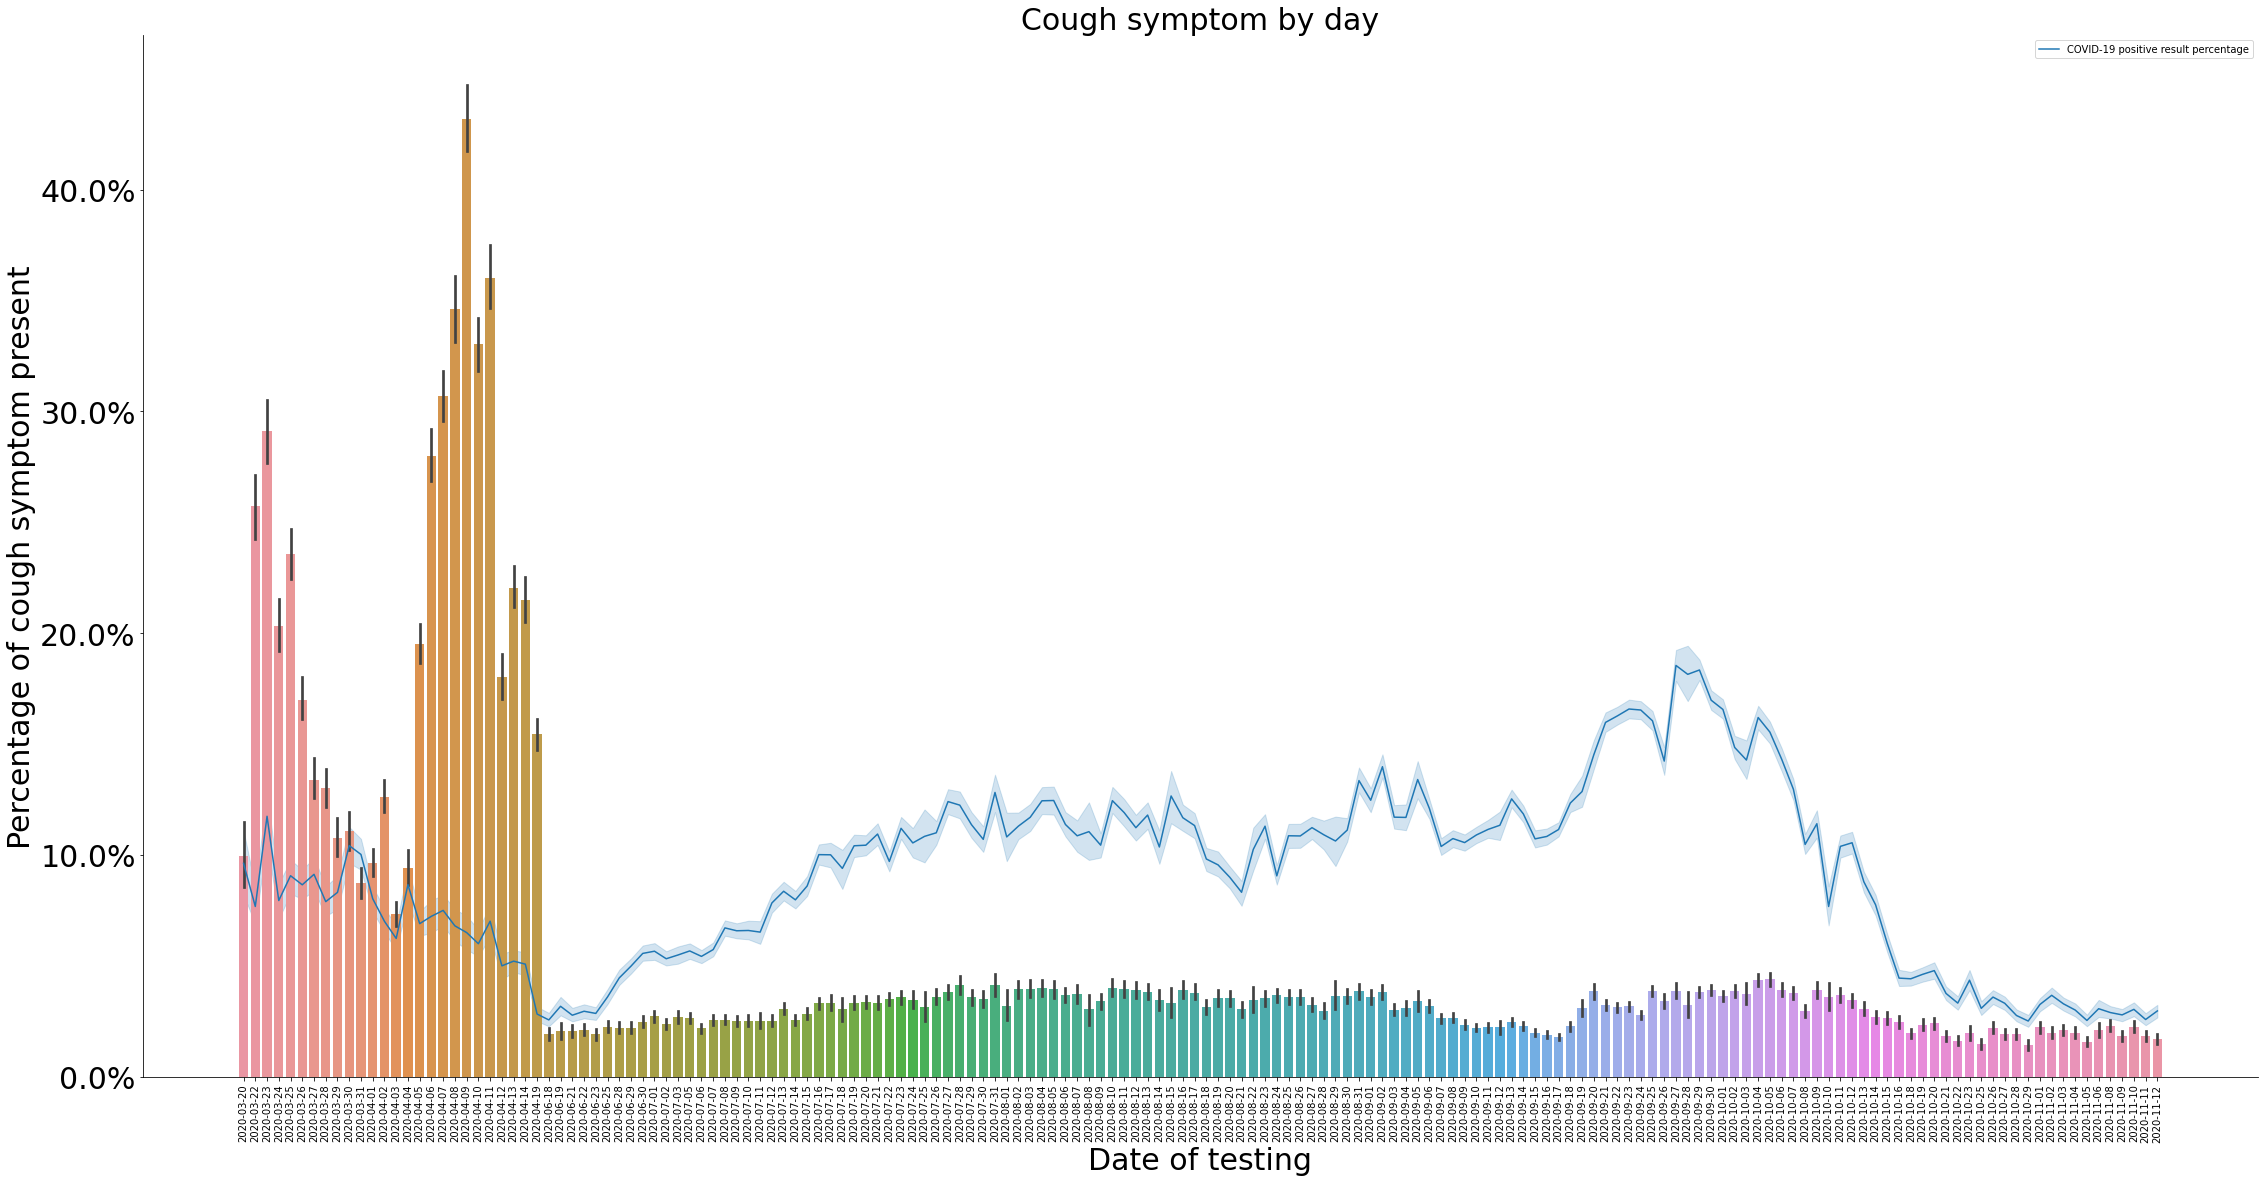

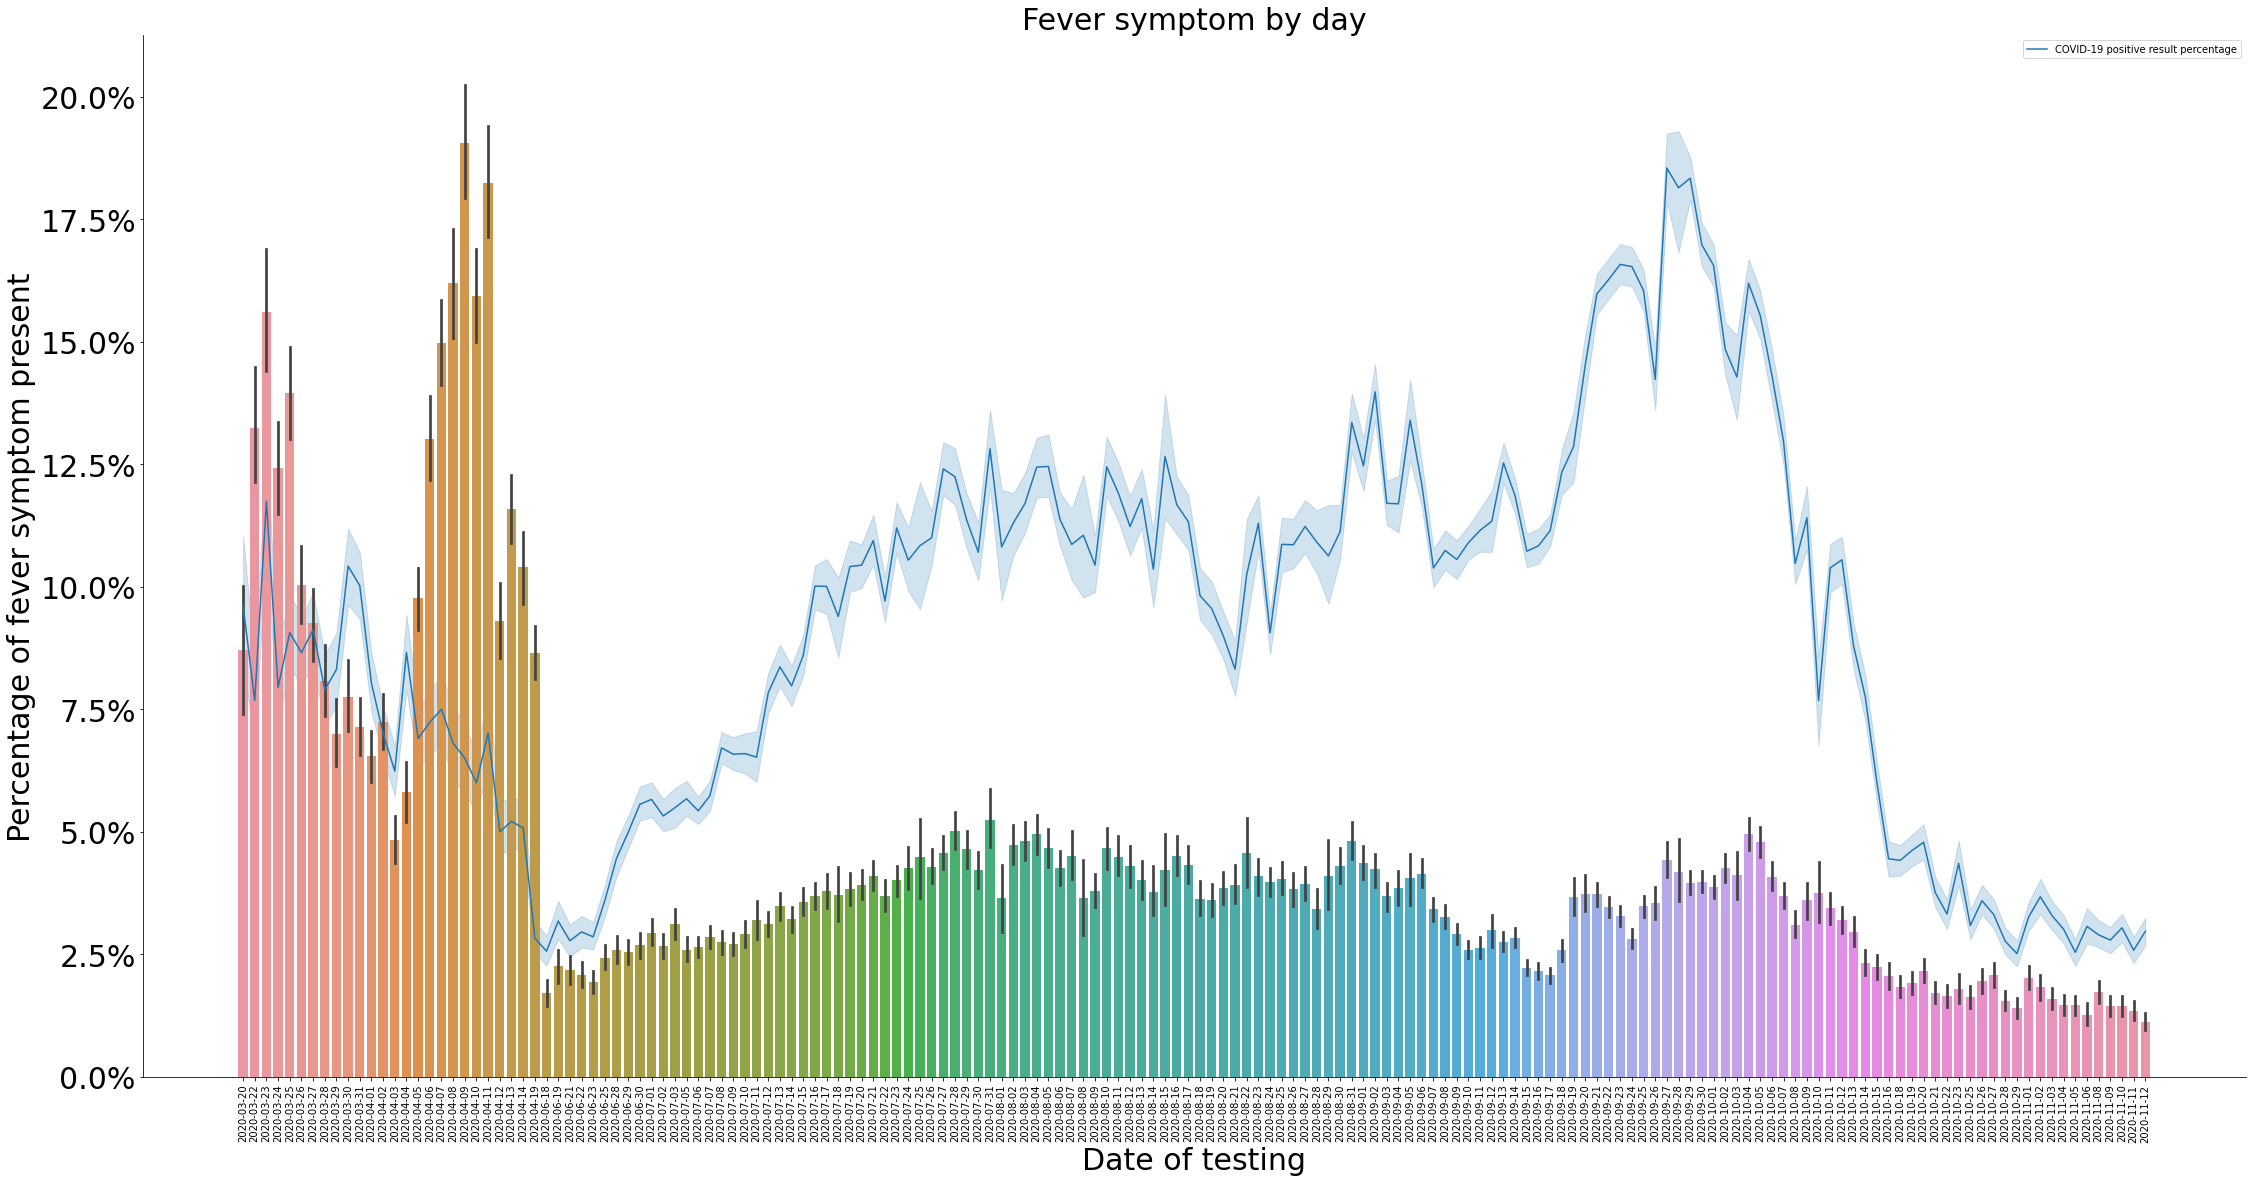

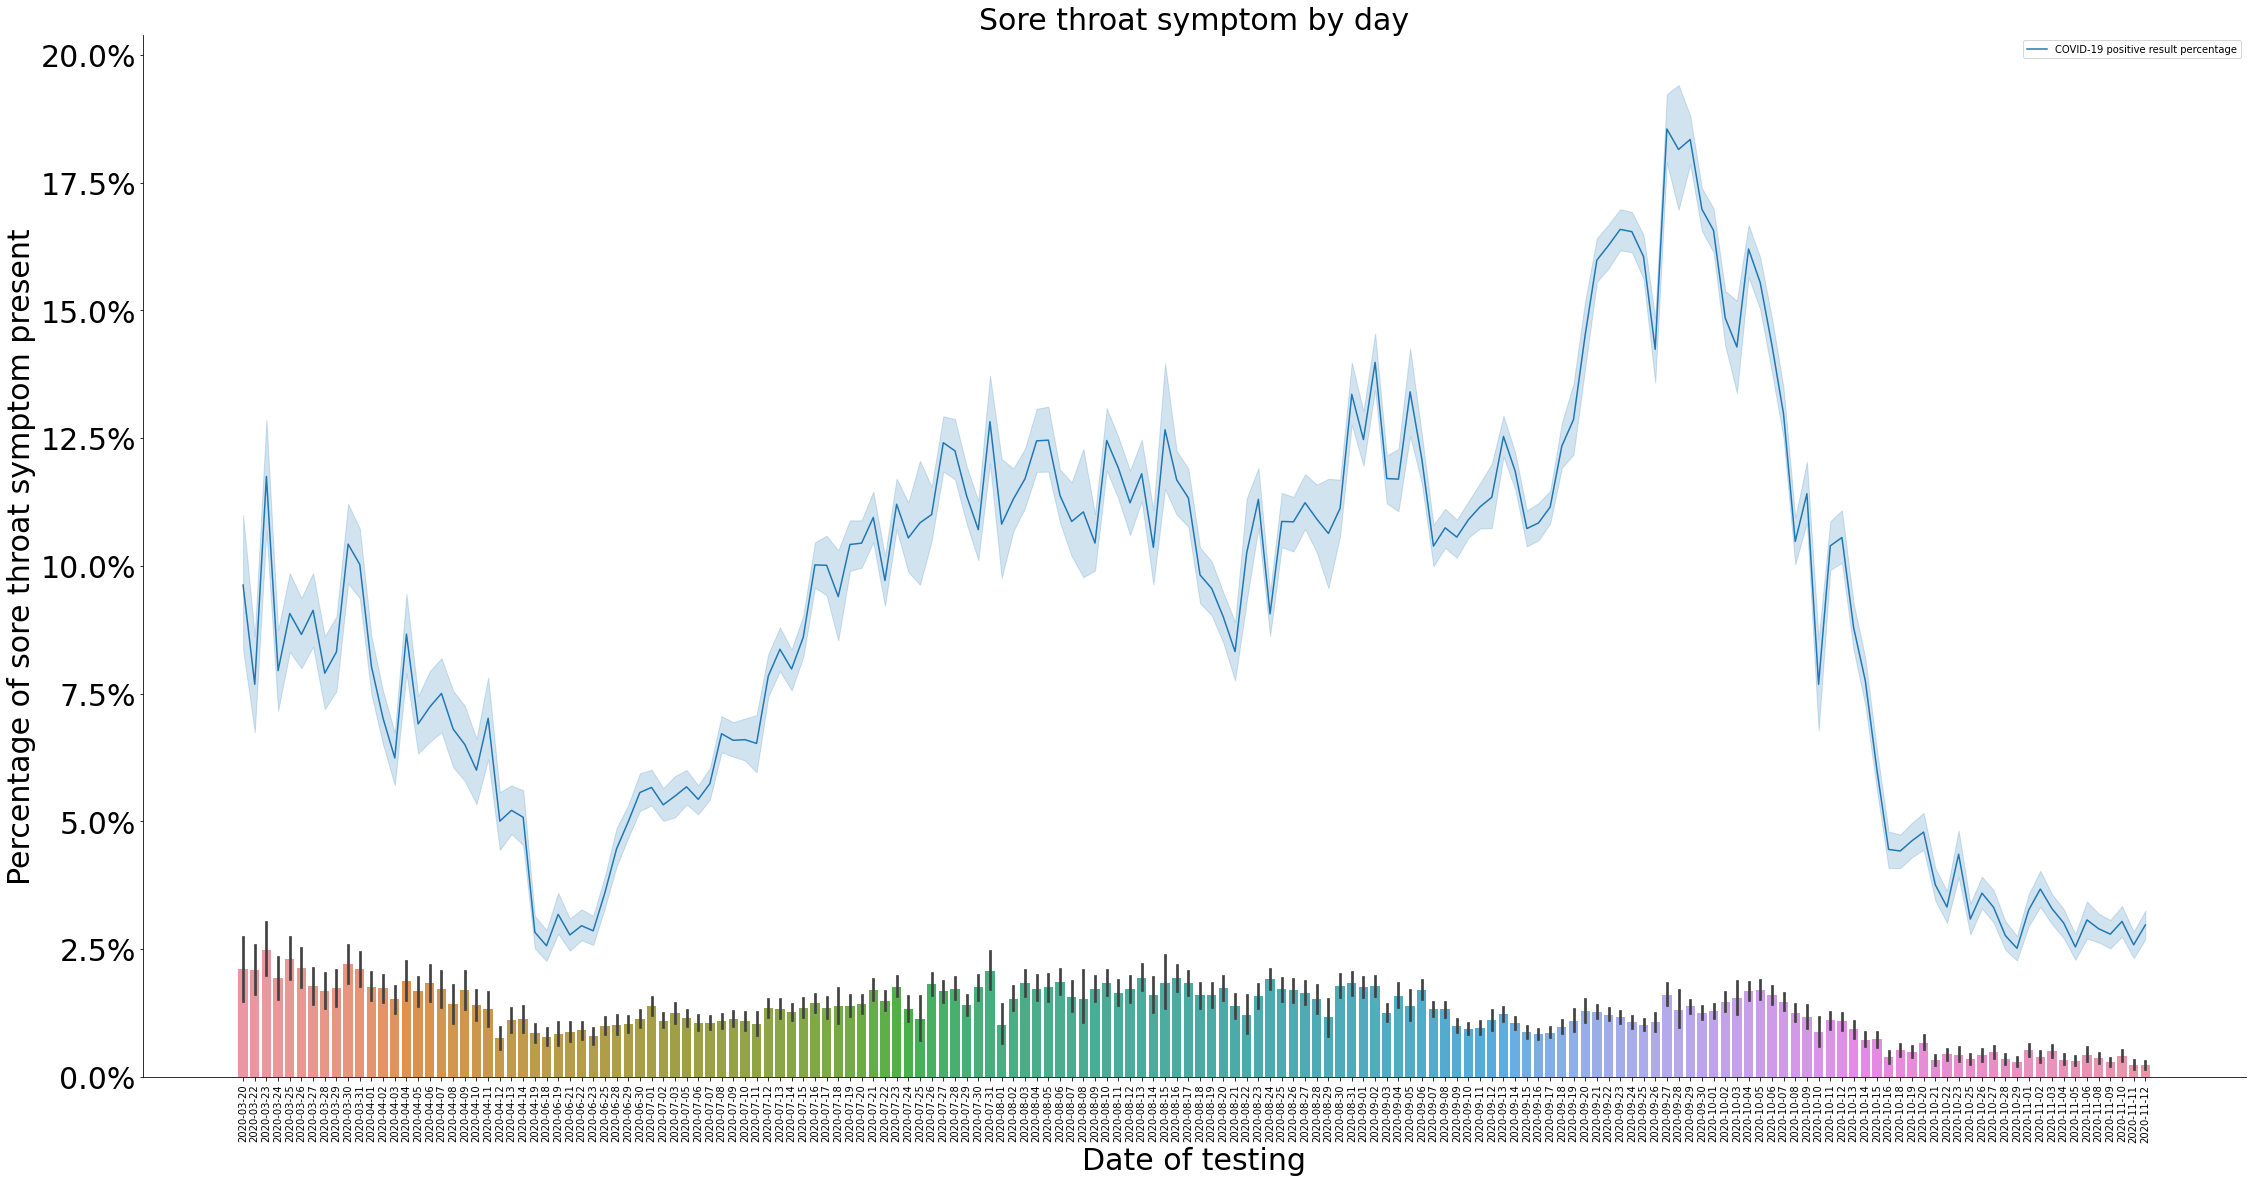

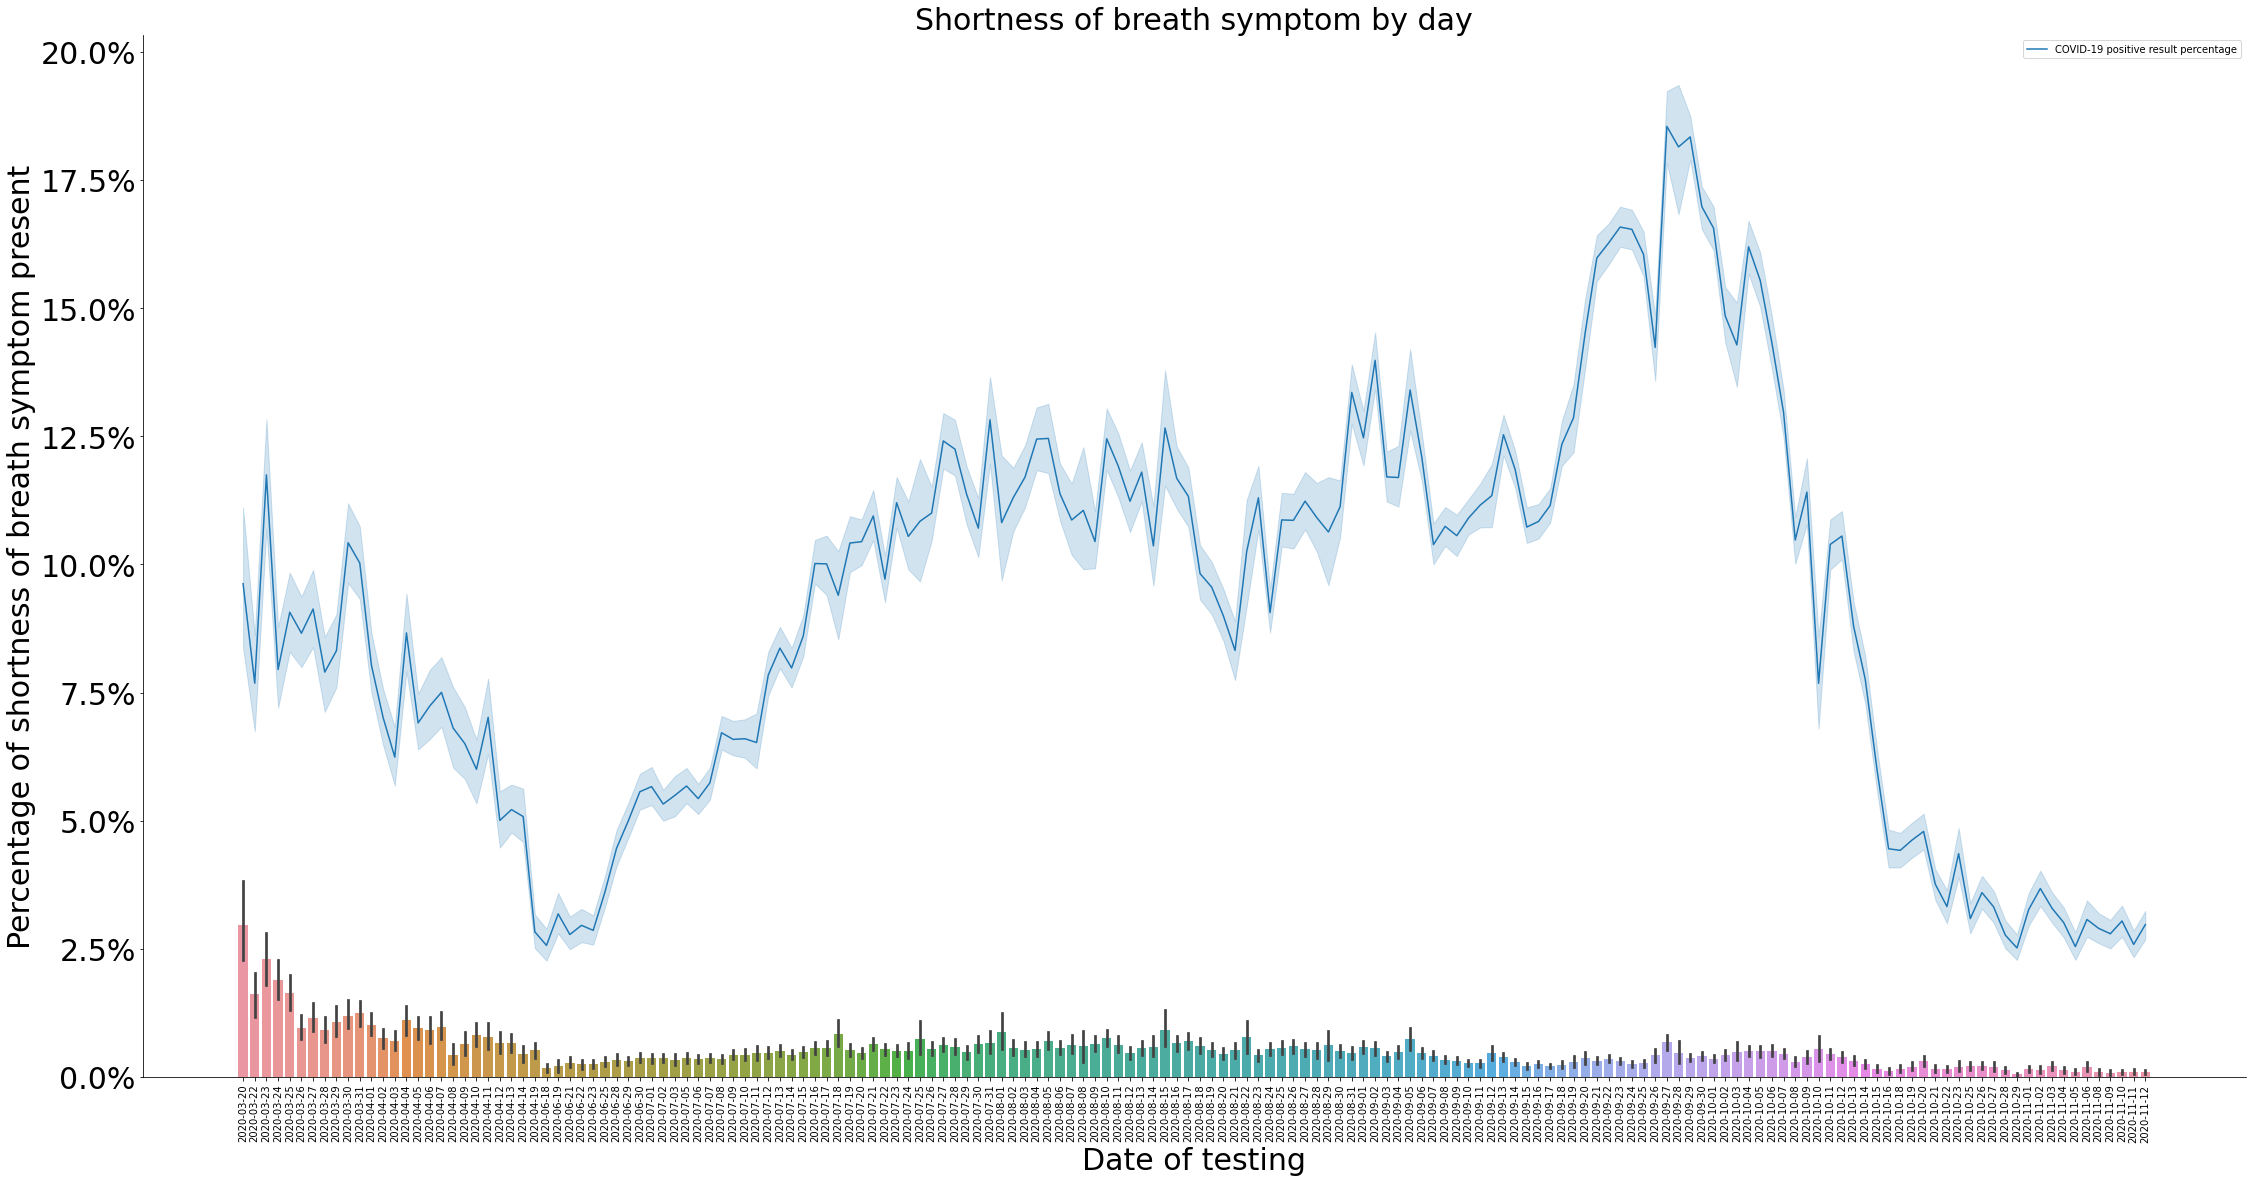

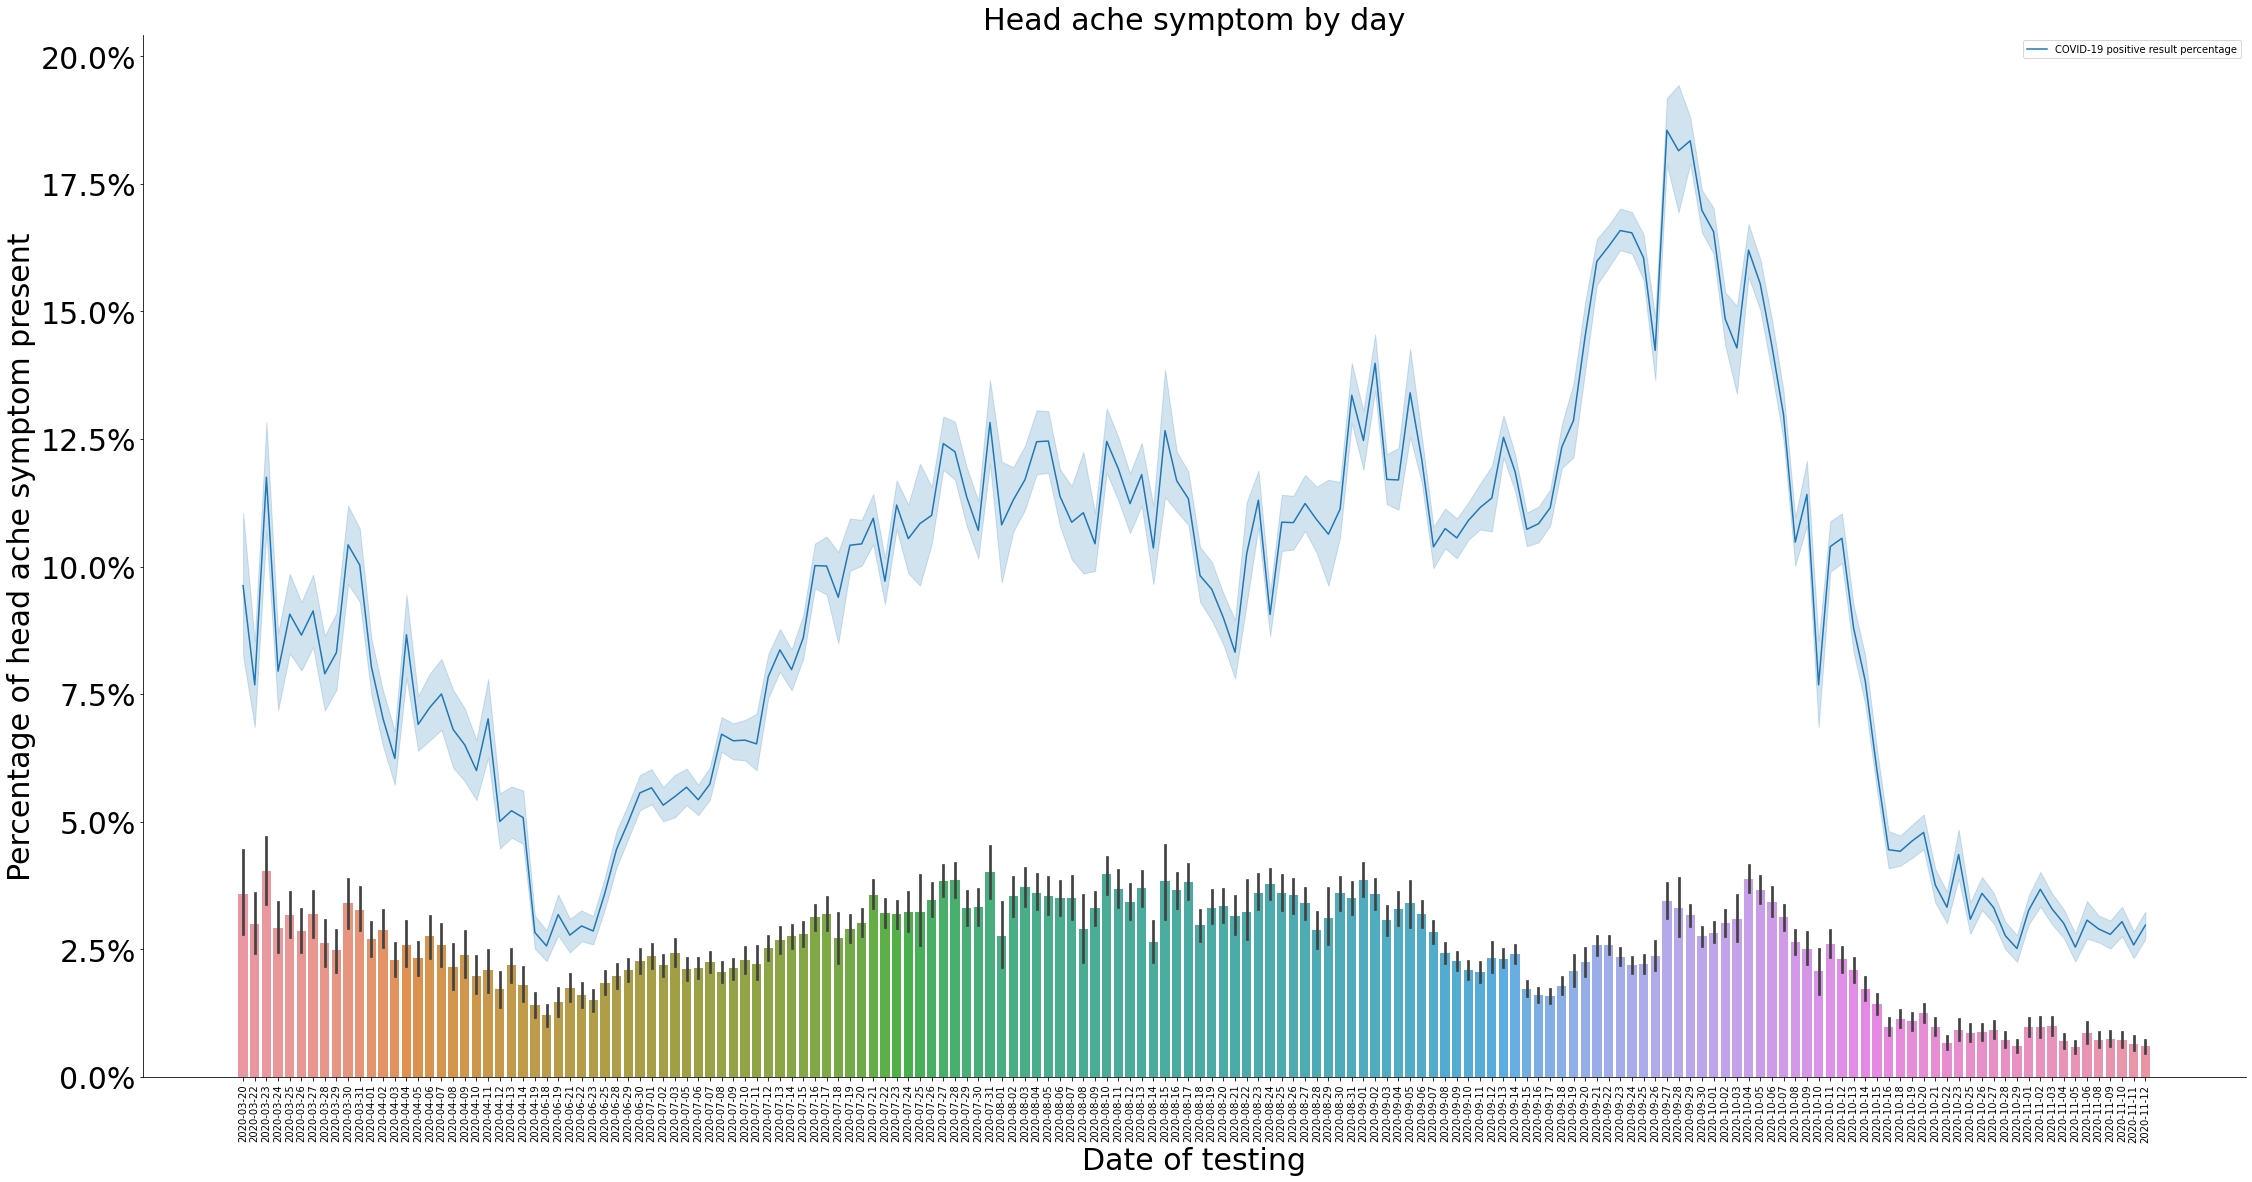

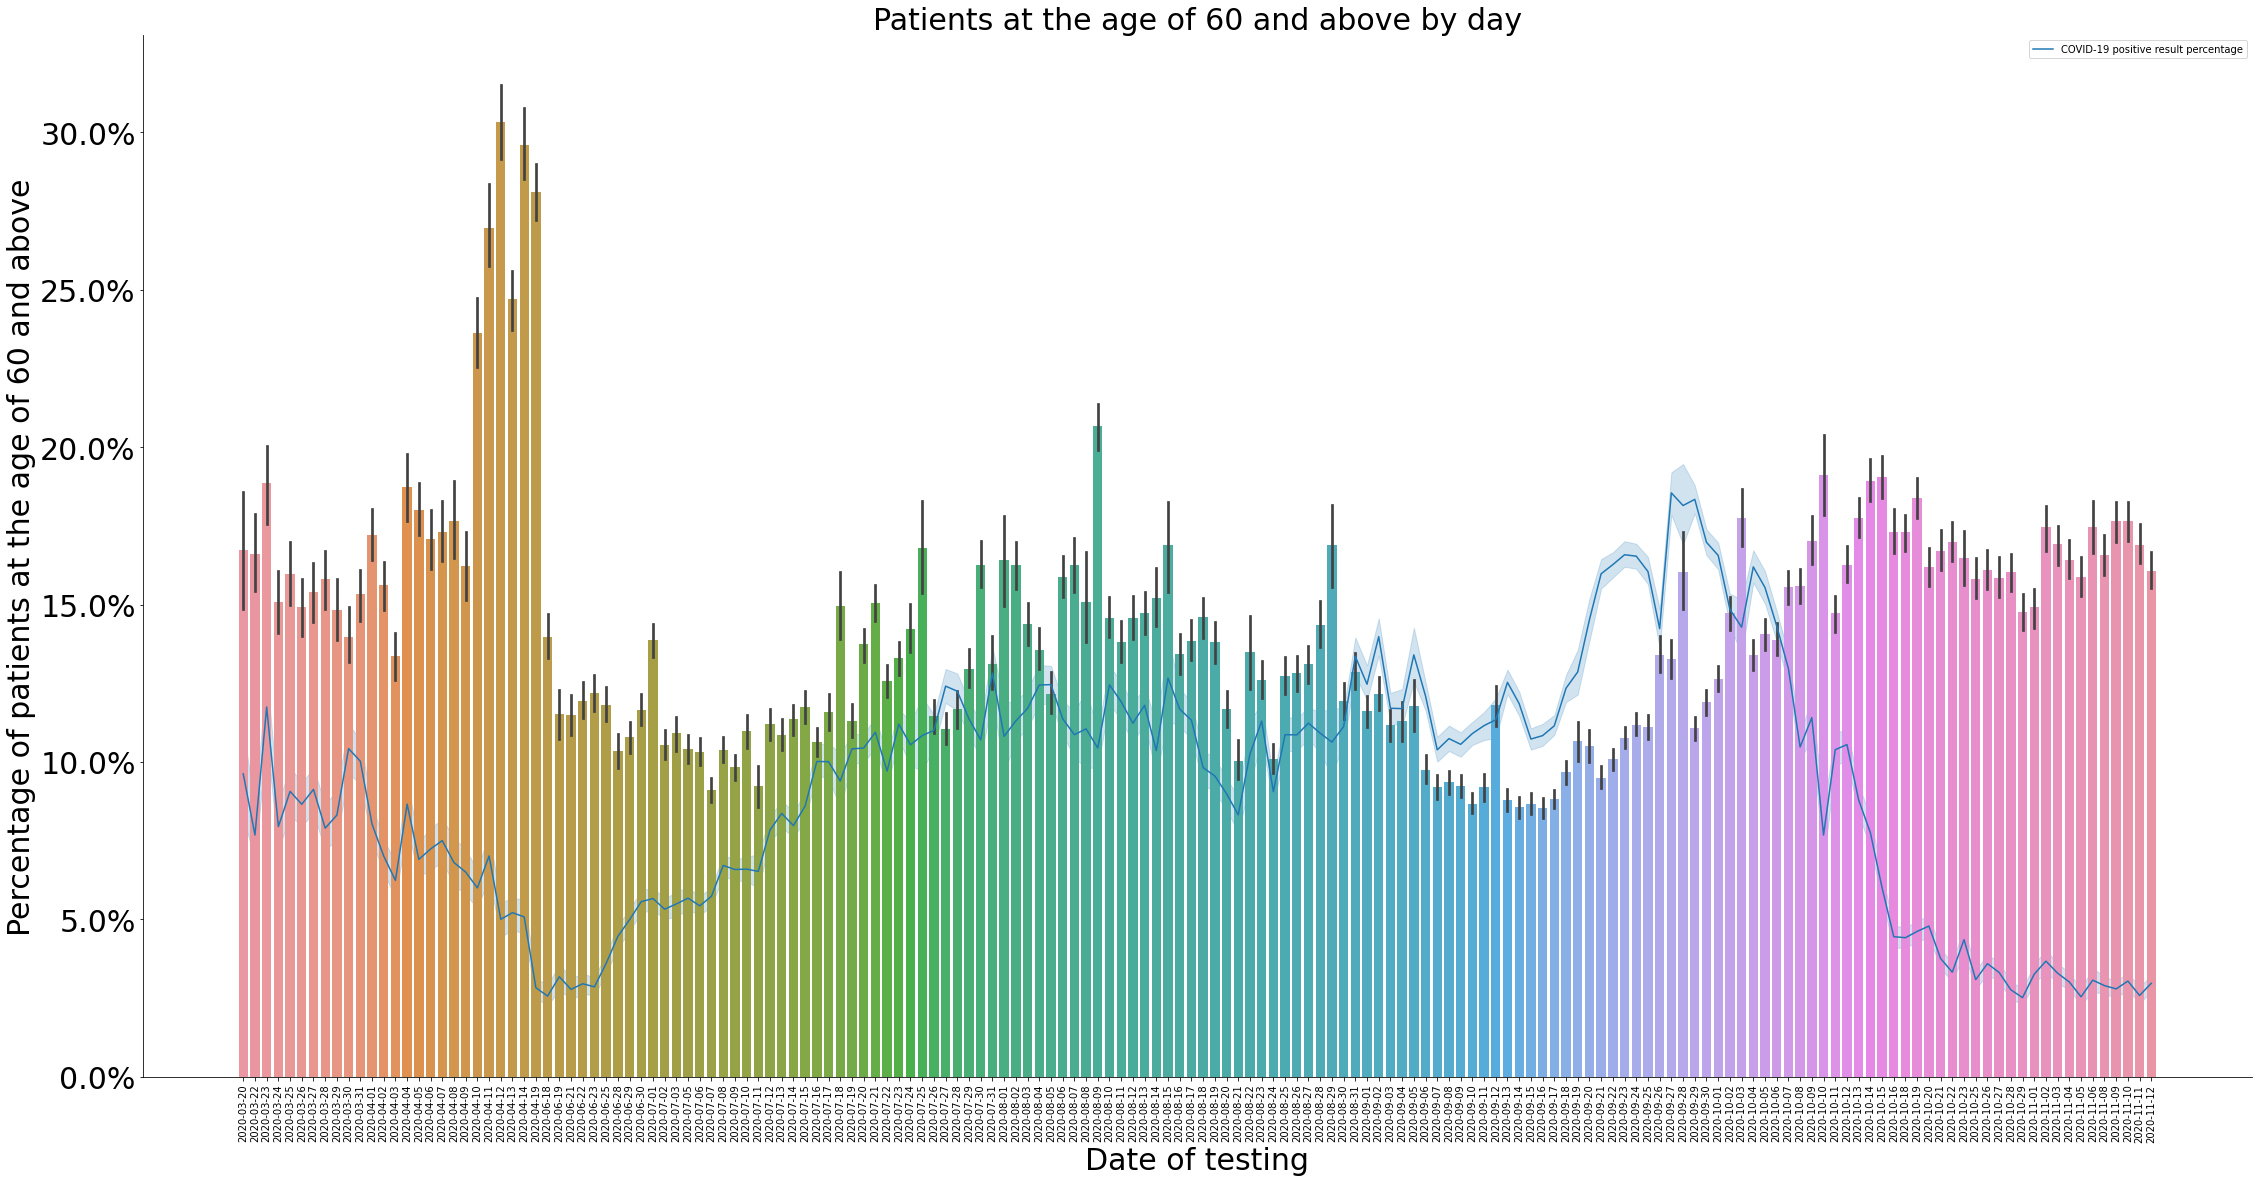

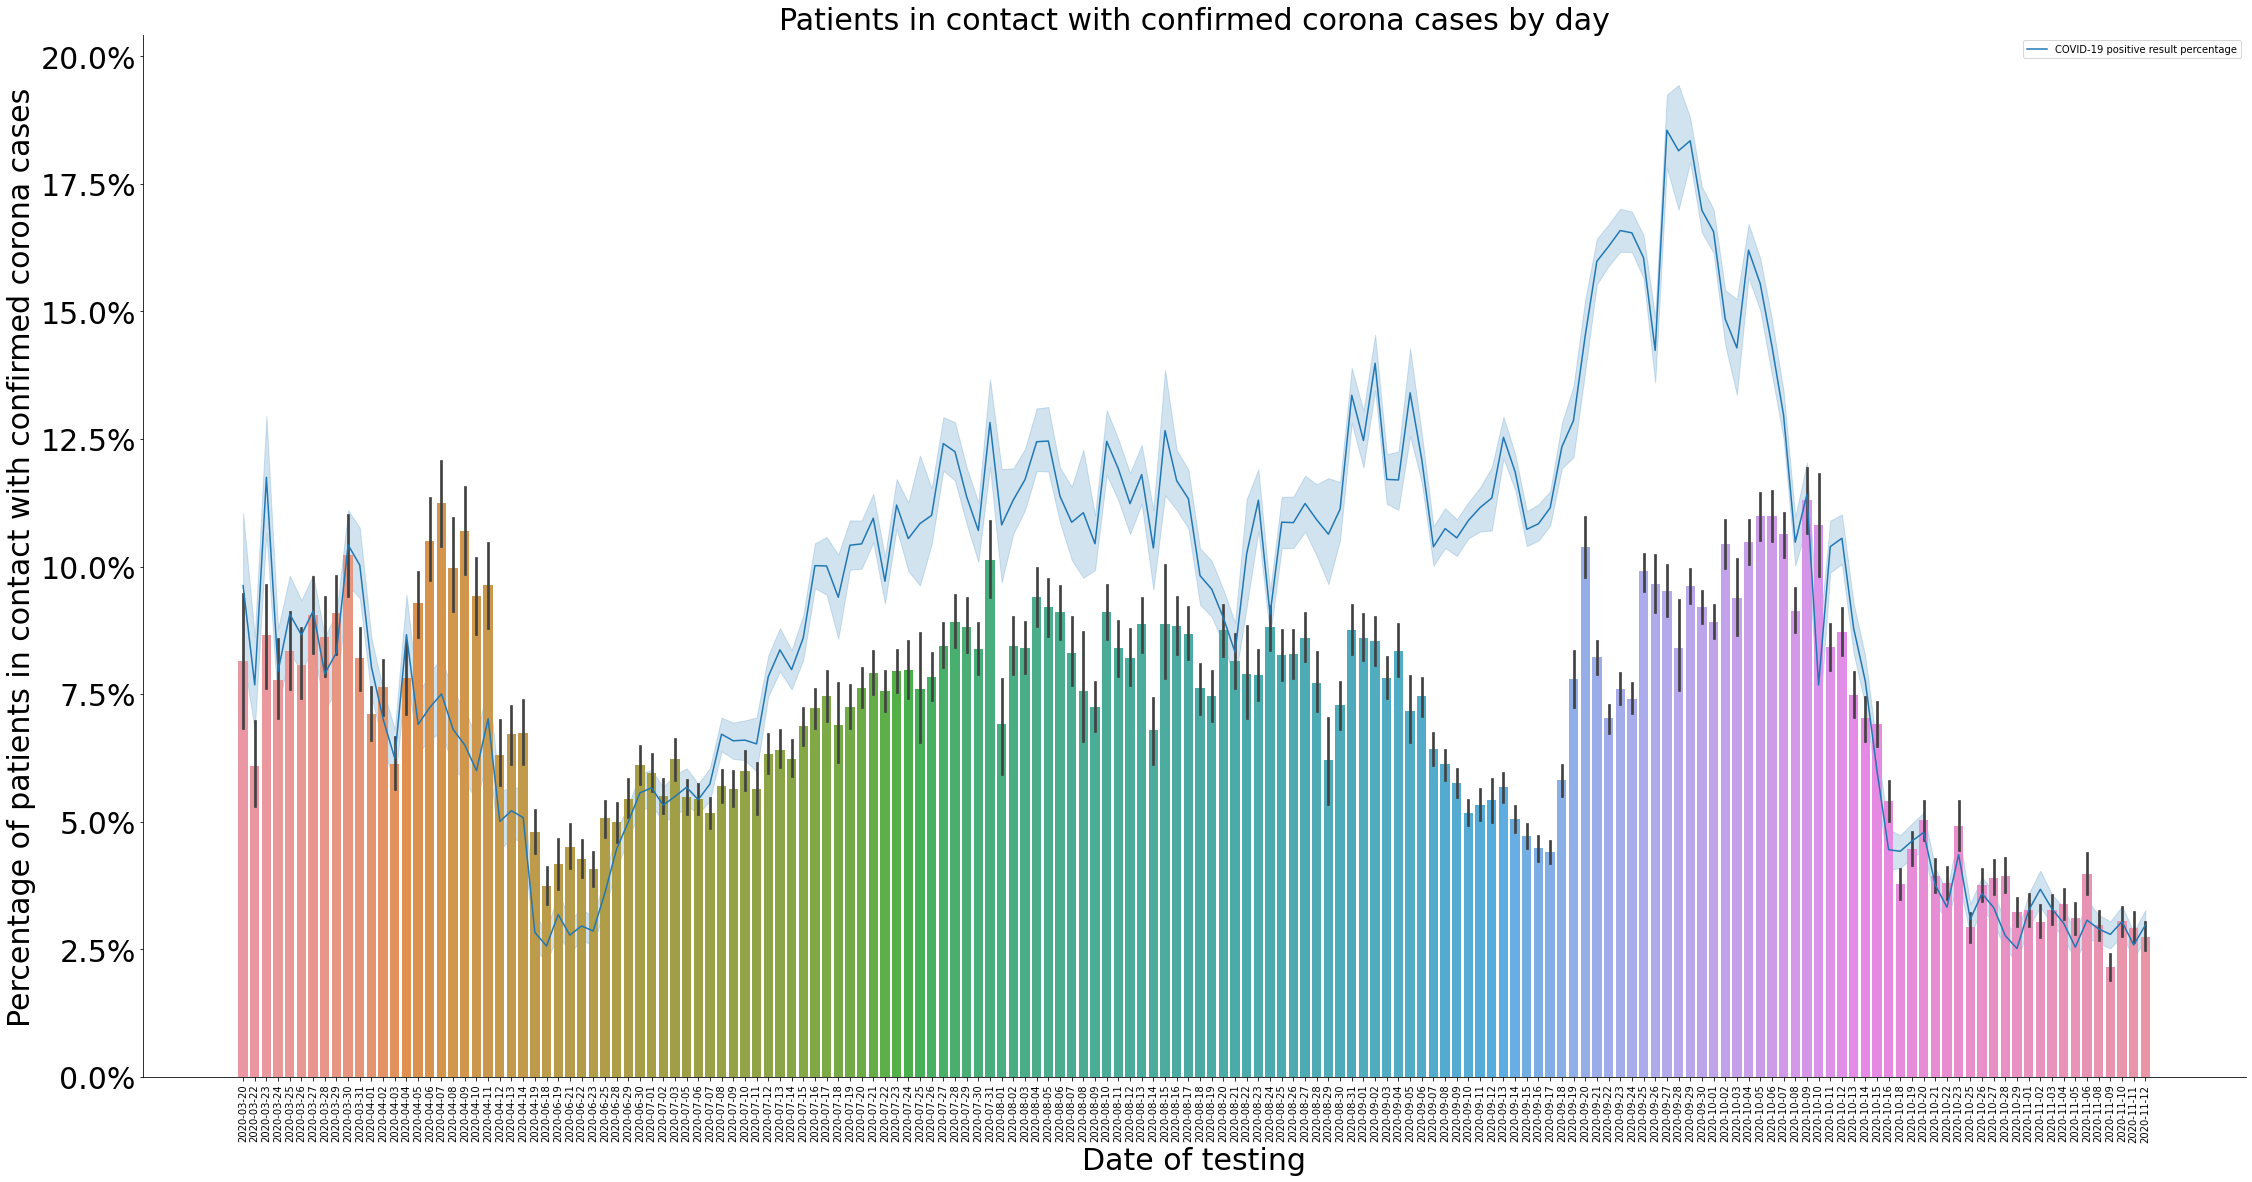

In [705]:
sns.catplot(x='test_date', y='cough', data=df,\
            kind='bar', height=15, aspect=2, legend=True)\
            .map(sns.lineplot, x='test_date', y='corona_result', data=df, label='COVID-19 positive result percentage')


plt.title('Cough symptom by day', size=30)
plt.xticks(rotation=90, size=10)
plt.yticks(size=30)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Percentage of cough symptom present', size=30)
plt.xlabel('Date of testing', size=30)
plt.legend()

sns.catplot(x='test_date', y='fever', data=df,\
            kind='bar', height=15, aspect=2, legend=True)\
            .map(sns.lineplot, x='test_date', y='corona_result', data=df, label='COVID-19 positive result percentage')

plt.title('Fever symptom by day', size=30)
plt.xticks(rotation=90, size=10)
plt.yticks(size=30)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Percentage of fever symptom present', size=30)
plt.xlabel('Date of testing', size=30)
plt.legend()

sns.catplot(x='test_date', y='sore_throat', data=df,\
            kind='bar', height=15, aspect=2, legend=True)\
            .map(sns.lineplot, x='test_date', y='corona_result', data=df, label='COVID-19 positive result percentage')

plt.title('Sore throat symptom by day', size=30)
plt.xticks(rotation=90, size=10)
plt.yticks(size=30)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Percentage of sore throat symptom present', size=30)
plt.xlabel('Date of testing', size=30)
plt.legend()

sns.catplot(x='test_date', y='shortness_of_breath', data=df,\
            kind='bar', height=15, aspect=2, legend=True)\
            .map(sns.lineplot, x='test_date', y='corona_result', data=df, label='COVID-19 positive result percentage')

plt.title('Shortness of breath symptom by day', size=30)
plt.xticks(rotation=90, size=10)
plt.yticks(size=30)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Percentage of shortness of breath symptom present', size=30)
plt.xlabel('Date of testing', size=30)
plt.legend()

sns.catplot(x='test_date', y='head_ache', data=df,\
            kind='bar', height=15, aspect=2, legend=True)\
            .map(sns.lineplot, x='test_date', y='corona_result', data=df, label='COVID-19 positive result percentage')

plt.title('Head ache symptom by day', size=30)
plt.xticks(rotation=90, size=10)
plt.yticks(size=30)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Percentage of head ache symptom present', size=30)
plt.xlabel('Date of testing', size=30)
plt.legend()

sns.catplot(x='test_date', y='age_60_and_above', data=df,\
            kind='bar', height=15, aspect=2, legend=True)\
            .map(sns.lineplot, x='test_date', y='corona_result', data=df, label='COVID-19 positive result percentage')

plt.title('Patients at the age of 60 and above by day', size=30)
plt.xticks(rotation=90, size=10)
plt.yticks(size=30)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Percentage of patients at the age of 60 and above', size=30)
plt.xlabel('Date of testing', size=30)
plt.legend()


sns.catplot(x='test_date', y='test_indication', data=df,\
            kind='bar', height=15, aspect=2, legend=True)\
            .map(sns.lineplot, x='test_date', y='corona_result', data=df, label='COVID-19 positive result percentage')

plt.title('Patients in contact with confirmed corona cases by day', size=30)
plt.xticks(rotation=90, size=10)
plt.yticks(size=30)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Percentage of patients in contact with confirmed corona cases', size=30)
plt.xlabel('Date of testing', size=30)
plt.legend()

plt.show()

#### Data split

In [706]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y) # stratify to balance the data

#### Preprocessing data
The data was already transformed to `int` 0/1 values where possible.  
No scaling needed since the work is done on binary categorical data.

#### Decision Tree Classifier

In [707]:
dtc = DecisionTreeClassifier(max_depth=5)

In [708]:
dtc_fit = dtc.fit(X_train, y_train)

In [709]:
unique, counts = np.unique(dtc.predict(X_test), return_counts=True)
print(f'The amounts of True (positive)/False (negative) cases predicted by the model:\n{dict(zip(unique, counts))}')

The amounts of True (positive)/False (negative) cases predicted by the model:
{0.0: 391221, 1.0: 39159}


### Calculating model evaluation metrics

In [710]:
print(f"Model accuracy: {round(dtc_fit.score(X_test,y_test),3)}")

Model accuracy: 0.929


The accuracy score appears high, which is most likely caused by imbalanced data.

In [711]:
scores_dtc = cross_validate(dtc, X_train, y_train, cv=5)
# cv computes the data 5 times with different splits

In [712]:
print(f"Cross validation score mean: {round(scores_dtc['test_score'].mean(), 3)}")

Cross validation score mean: 0.929


In [713]:
print(f"Cross validation score standard deviation: {round(scores_dtc['test_score'].std(), 6)}")

Cross validation score standard deviation: 0.000331


In [714]:
pred_proba_dtc = dtc.predict_proba(X_test)

In [715]:
y_pred_dtc = dtc.predict(X_test)

In [716]:
fpr_dtc, tpr_dtc, thresholds_dtc = roc_curve(y_test, pred_proba_dtc[:,1])
roc_auc_dtc = auc(fpr_dtc, tpr_dtc)

In [717]:
tn_dtc, fp_dtc, fn_dtc, tp_dtc=confusion_matrix(y_test, y_pred_dtc).ravel()

In [718]:
model_specificity_dtc = tp_dtc/(fp_dtc+tp_dtc)
print(f"Model specificity: {round(model_specificity_dtc, 3)}")

Model specificity: 0.641


In [719]:
model_sensitivity_dtc = tp_dtc/(fn_dtc+tp_dtc)
print(f"Model sensitivity: {round(model_sensitivity_dtc, 3)}")

Model sensitivity: 0.601


In [720]:
model_precision_dtc = tp_dtc/(tp_dtc+fp_dtc)
print(f"Model precision: {round(model_precision_dtc, 3)}")

Model precision: 0.641


In [721]:
f1_dtc = 2 * (model_precision_dtc * model_sensitivity_dtc) / (model_precision_dtc + model_sensitivity_dtc)
print(f"F1 score = {round(f1_dtc, 3)}")

F1 score = 0.621


Applying Cohen Kappa metric is built on the premise of higly imbalanced data.

In [722]:
model_cohen_kappa_dtc = cohen_kappa_score(y_test, y_pred_dtc)
print(f"Cohen Kappa score = {round(model_cohen_kappa_dtc, 3)}")

Cohen Kappa score = 0.581


##### Calculating AUC ROC value

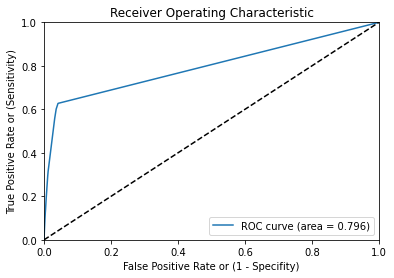

In [723]:
plt.plot(fpr_dtc, tpr_dtc, label=f'ROC curve (area = {round(roc_auc_dtc, 3)})')
plt.plot([0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [724]:
print(f"Area Under Curve of Receiver Operating Characteristic: \
{round(roc_auc_score(y_test, pred_proba_dtc[:,1]), 3)}")

Area Under Curve of Receiver Operating Characteristic: 0.796


#### Feature importance calculation

In [725]:
features = list(X.columns)

In [726]:
dtc_importance = dtc.feature_importances_
indices_dtc = np.argsort(dtc_importance)

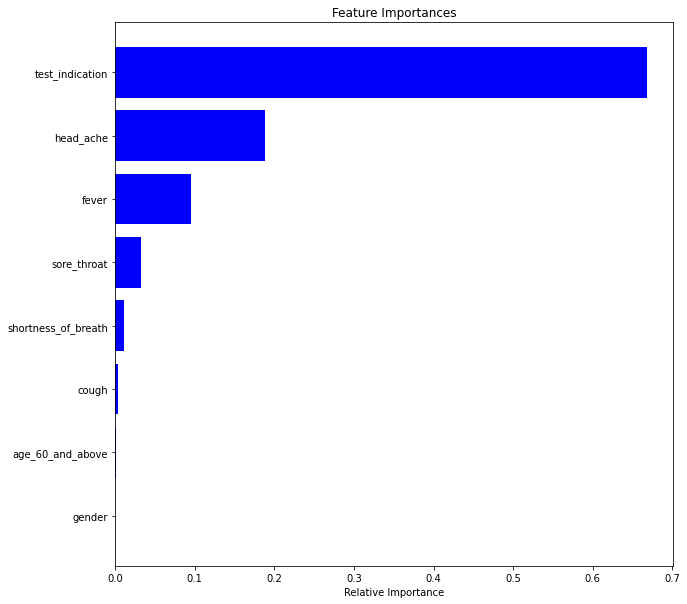

In [727]:
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices_dtc)), dtc_importance[indices_dtc], color='b', align='center')
plt.yticks(range(len(indices_dtc)), [features[i] for i in indices_dtc])
plt.xlabel('Relative Importance')
plt.show()

In [730]:
for i,v in enumerate(dtc_importance):
    print(f'Feature: {feature_names[i]}, Score: {round(v, 5)}')

Feature: cough, Score: 0.00385
Feature: fever, Score: 0.09479
Feature: sore_throat, Score: 0.03315
Feature: shortness_of_breath, Score: 0.01103
Feature: head_ache, Score: 0.18891
Feature: age_60_and_above, Score: 0.0007
Feature: gender, Score: 9e-05
Feature: test_indication, Score: 0.66748


#### Decision Tree plot

[Text(837.0, 996.6, 'test_indication <= 0.5\ngini = 0.175\nsamples = 1721518\nvalue = [1554537, 166981]\nclass = male'),
 Text(418.5, 815.4000000000001, 'head_ache <= 0.5\ngini = 0.109\nsamples = 1603282\nvalue = [1510445, 92837]\nclass = male'),
 Text(209.25, 634.2, 'fever <= 0.5\ngini = 0.094\nsamples = 1585314\nvalue = [1506717, 78597]\nclass = male'),
 Text(104.625, 453.0, 'sore_throat <= 0.5\ngini = 0.08\nsamples = 1556339\nvalue = [1491006, 65333]\nclass = male'),
 Text(52.3125, 271.79999999999995, 'shortness_of_breath <= 0.5\ngini = 0.078\nsamples = 1553347\nvalue = [1490180, 63167]\nclass = male'),
 Text(26.15625, 90.59999999999991, 'gini = 0.077\nsamples = 1552292\nvalue = [1489937, 62355]\nclass = male'),
 Text(78.46875, 90.59999999999991, 'gini = 0.355\nsamples = 1055\nvalue = [243, 812]\nclass = female'),
 Text(156.9375, 271.79999999999995, 'age_60_and_above <= 0.5\ngini = 0.4\nsamples = 2992\nvalue = [826, 2166]\nclass = female'),
 Text(130.78125, 90.59999999999991, 'gini 

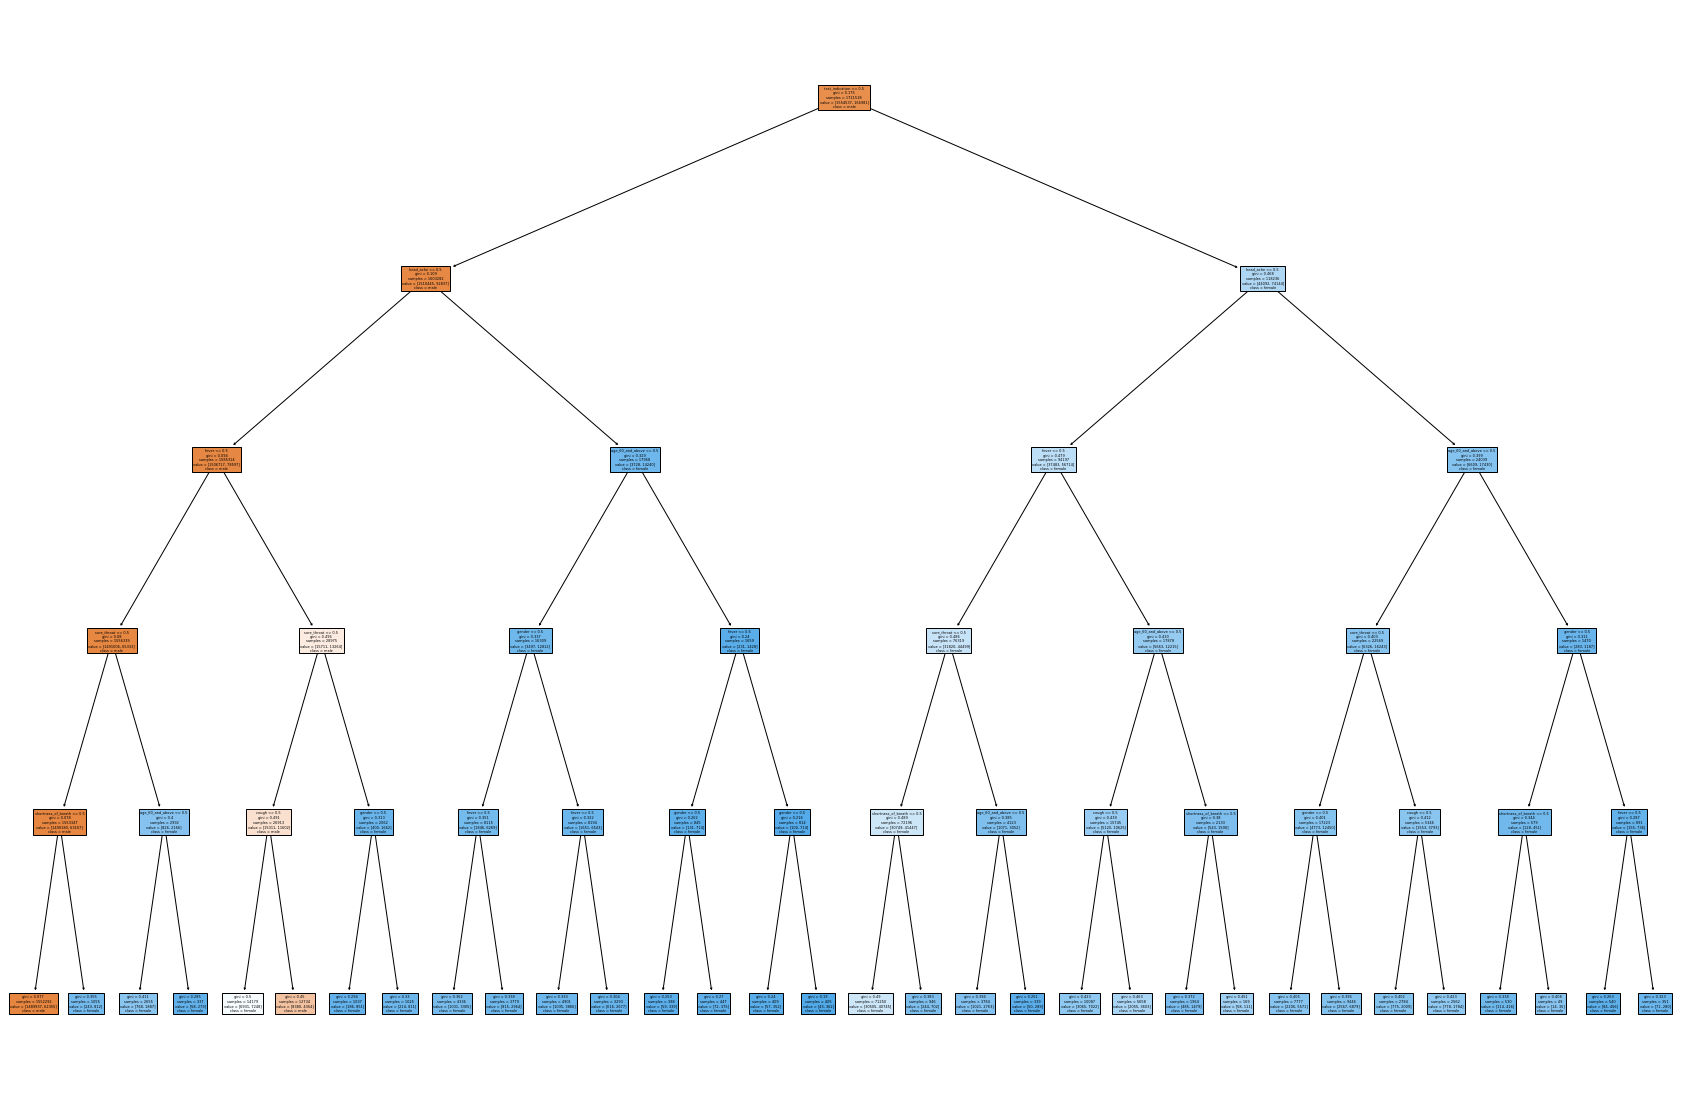

In [731]:
plt.figure(figsize=(30,20))
tree.plot_tree(dtc, feature_names=features, class_names=['male', 'female'], filled=True)

#### Random Forest classifier

In [732]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=5)
#, n_estimators=500
#, max_depth=5
#, 

In [733]:
rfc_fit = rfc.fit(X_train, y_train)

In [734]:
unique, counts = np.unique(rfc.predict(X_test), return_counts=True)
print(f'The amounts of True (positive)/False (negative) cases predicted by the model:\n{dict(zip(unique, counts))}')

The amounts of True (positive)/False (negative) cases predicted by the model:
{0.0: 410573, 1.0: 19807}


### Calculating model evaluation metrics

In [735]:
print(f"Model accuracy: {round(rfc_fit.score(X_test,y_test),3)}")

Model accuracy: 0.923


The accuracy score appears high, which is most likely caused by imbalanced data.

In [736]:
scores_rfc = cross_validate(rfc, X_train, y_train, cv=5)

In [737]:
print(f"Cross validation score mean: {round(scores_rfc['test_score'].mean(), 3)}")

Cross validation score mean: 0.923


In [738]:
print(f"Cross validation score standard deviation: {round(scores_rfc['test_score'].std(), 6)}")

Cross validation score standard deviation: 0.000145


In [739]:
pred_proba_rfc = rfc.predict_proba(X_test)

In [740]:
y_pred_rfc = rfc.predict(X_test)

In [741]:
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y_test, pred_proba_rfc[:,1])
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

In [742]:
tn_rfc, fp_rfc, fn_rfc, tp_rfc=confusion_matrix(y_test, y_pred_rfc).ravel()

In [743]:
model_specificity_rfc = tp_rfc/(fp_rfc+tp_rfc)
print(f"Model specificity: {round(model_specificity_rfc, 3)}")

Model specificity: 0.715


In [744]:
model_sensitivity_rfc = tp_rfc/(fn_rfc+tp_rfc)
print(f"Model sensitivity: {round(model_sensitivity_rfc, 3)}")

Model sensitivity: 0.339


In [745]:
model_precision_rfc = tp_rfc/(tp_rfc+fp_rfc)
print(f"Model precision: {round(model_precision_rfc, 3)}")

Model precision: 0.715


In [746]:
f1_rfc = 2 * (model_precision_rfc * model_sensitivity_rfc) / (model_precision_rfc + model_sensitivity_rfc)
print(f"F1 score = {round(f1_rfc, 3)}")

F1 score = 0.46


Applying Cohen Kappa metric is built on the premise of higly imbalanced data.

In [747]:
model_cohen_kappa_rfc = cohen_kappa_score(y_test, y_pred_rfc)
print(f"Cohen Kappa score = {round(model_cohen_kappa_rfc, 3)}")

Cohen Kappa score = 0.424


##### Calculating AUC ROC value

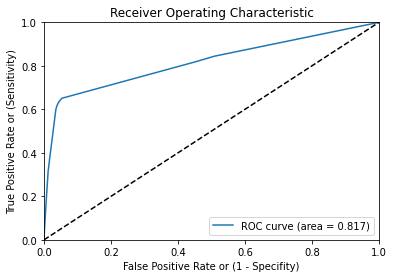

In [748]:
plt.plot(fpr_rfc, tpr_rfc, label=f'ROC curve (area = {round(roc_auc_rfc, 3)})')
plt.plot([0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [749]:
print(f"Area Under Curve of Receiver Operating Characteristic: \
{round(roc_auc_score(y_test, pred_proba_rfc[:,1]), 3)}")

Area Under Curve of Receiver Operating Characteristic: 0.817


#### Feature importance calculation

In [750]:
rfc_importance = rfc.feature_importances_
indices_rfc = np.argsort(rfc_importance)

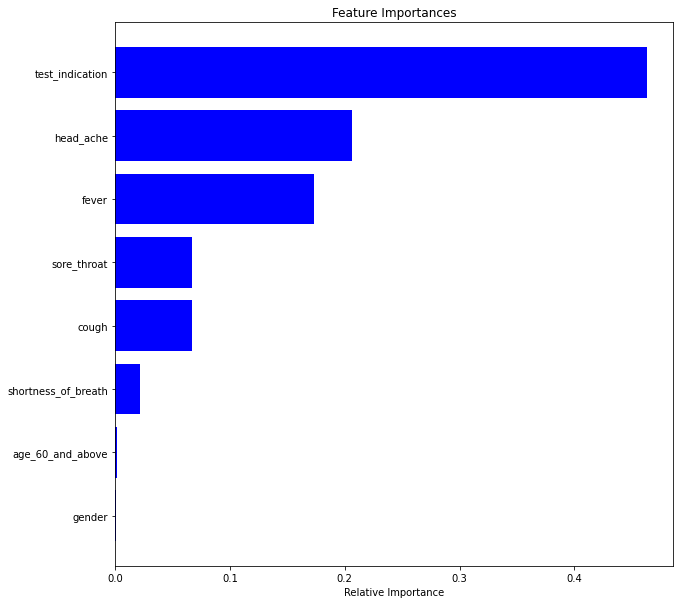

In [751]:
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices_rfc)), rfc_importance[indices_rfc], color='b', align='center')
plt.yticks(range(len(indices_rfc)), [features[i] for i in indices_rfc])
plt.xlabel('Relative Importance')
plt.show()

In [752]:
for i,v in enumerate(rfc_importance):
    print(f'Feature: {feature_names[i]}, Score: {round(v, 5)}')

Feature: cough, Score: 0.067
Feature: fever, Score: 0.17286
Feature: sore_throat, Score: 0.06701
Feature: shortness_of_breath, Score: 0.02171
Feature: head_ache, Score: 0.20653
Feature: age_60_and_above, Score: 0.00135
Feature: gender, Score: 0.0008
Feature: test_indication, Score: 0.46273


#### Plot a sample tree from the Forest

[Text(837.0, 996.6, 'cough <= 0.5\ngini = 0.175\nsamples = 1088269\nvalue = [1555125, 166393]\nclass = male'),
 Text(418.5, 815.4000000000001, 'shortness_of_breath <= 0.5\ngini = 0.15\nsamples = 1044347\nvalue = [1517257, 134596]\nclass = male'),
 Text(209.25, 634.2, 'fever <= 0.5\ngini = 0.148\nsamples = 1042334\nvalue = [1516440, 132232]\nclass = male'),
 Text(104.625, 453.0, 'test_indication <= 0.5\ngini = 0.127\nsamples = 1020221\nvalue = [1504013, 109652]\nclass = male'),
 Text(52.3125, 271.79999999999995, 'gender <= 0.5\ngini = 0.081\nsamples = 972837\nvalue = [1473924, 64872]\nclass = male'),
 Text(26.15625, 90.59999999999991, 'gini = 0.089\nsamples = 470620\nvalue = [709424, 34940]\nclass = male'),
 Text(78.46875, 90.59999999999991, 'gini = 0.073\nsamples = 502217\nvalue = [764500, 29932]\nclass = male'),
 Text(156.9375, 271.79999999999995, 'gender <= 0.5\ngini = 0.481\nsamples = 47384\nvalue = [30089, 44780]\nclass = female'),
 Text(130.78125, 90.59999999999991, 'gini = 0.484\

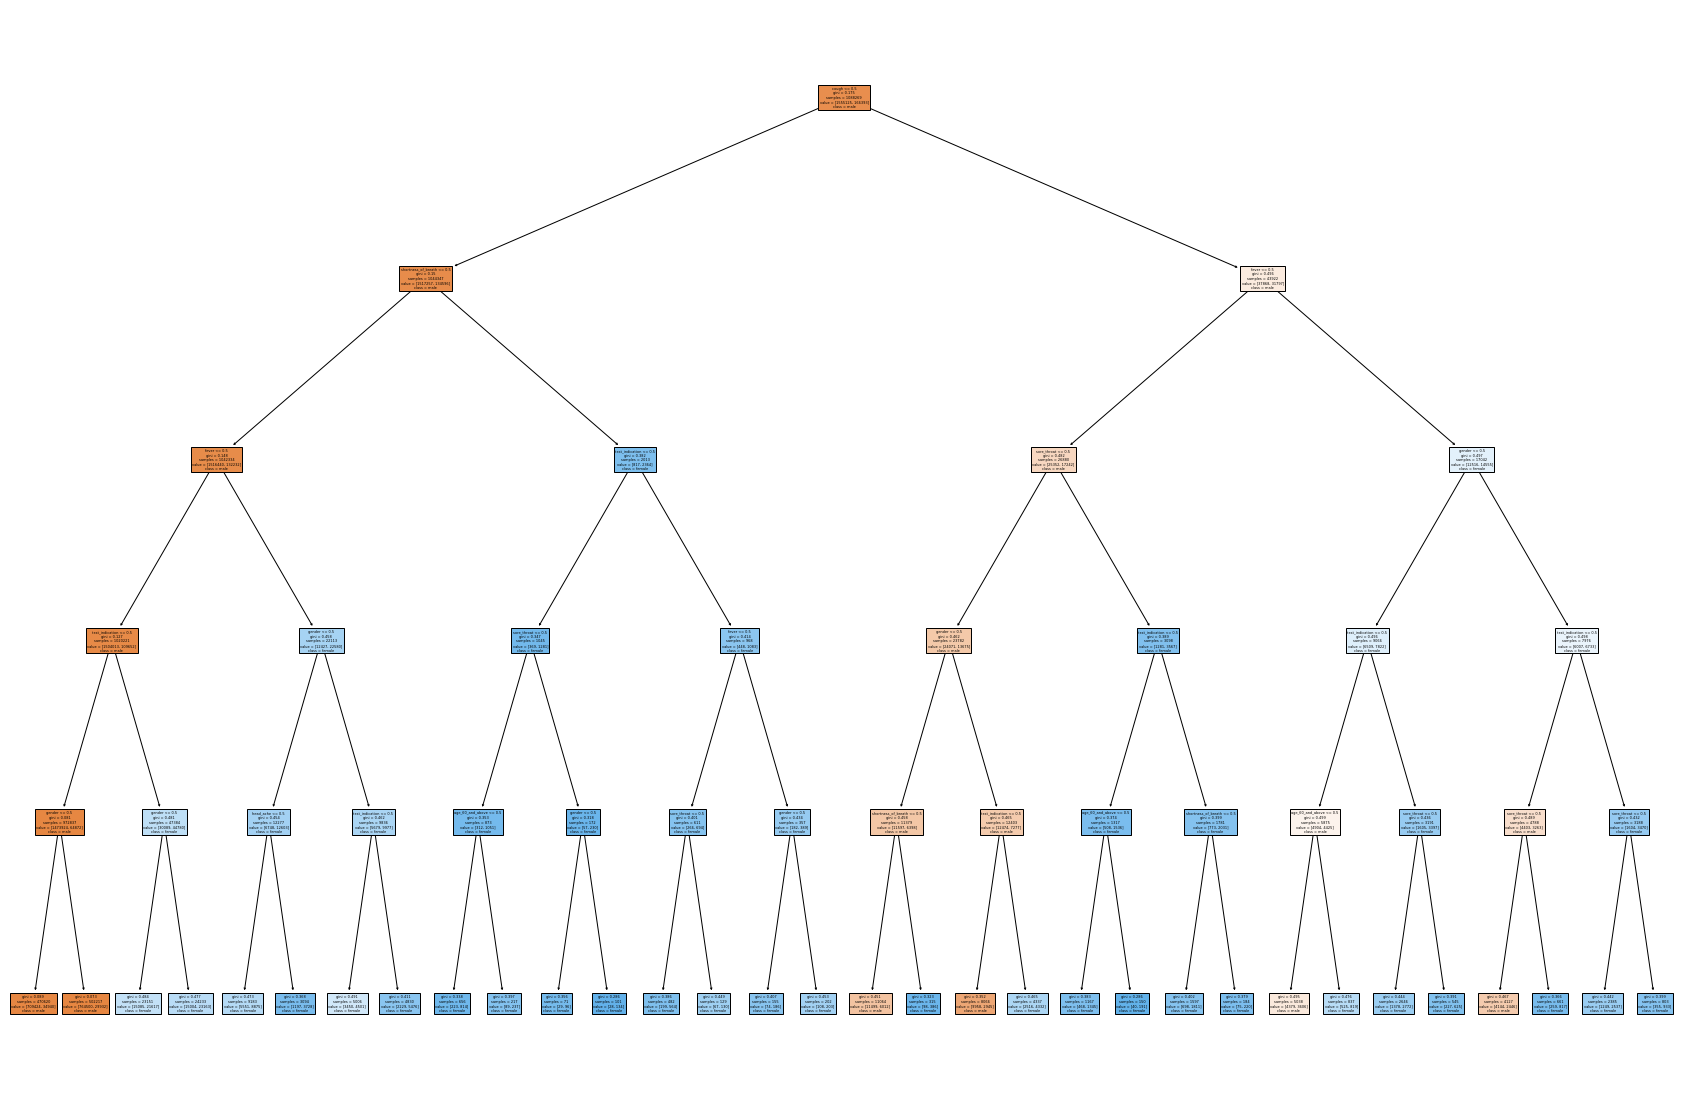

In [753]:
plt.figure(figsize=(30,20))
tree.plot_tree(rfc.estimators_[0], feature_names=features, class_names=['male', 'female'], filled=True)

#### Gradient Boosting classifier

In [754]:
gbc = GradientBoostingClassifier(n_estimators=500, max_depth=5)
#, n_estimators=500
#, max_depth=5

In [755]:
gbc_fit = gbc.fit(X_train, y_train)

In [756]:
unique, counts = np.unique(gbc.predict(X_test), return_counts=True)
print(f'The amounts of True (positive)/False (negative) cases predicted by the model:\n{dict(zip(unique, counts))}')

The amounts of True (positive)/False (negative) cases predicted by the model:
{0.0: 391992, 1.0: 38388}


### Calculating model evaluation metrics

In [757]:
print(f"Model accuracy: {round(gbc_fit.score(X_test,y_test),3)}")

Model accuracy: 0.929


The accuracy score appears high, which is most likely caused by imbalanced data.

In [758]:
scores_gbc = cross_validate(gbc, X_train, y_train, cv=5)

In [759]:
print(f"Cross validation score mean: {round(scores_gbc['test_score'].mean(), 3)}")

Cross validation score mean: 0.929


In [760]:
print(f"Cross validation score standard deviation: {round(scores_rfc['test_score'].std(), 6)}")

Cross validation score standard deviation: 0.000145


In [761]:
pred_proba_gbc = gbc.predict_proba(X_test)

In [762]:
y_pred_gbc = gbc.predict(X_test)

In [763]:
fpr_gbc, tpr_gbc, thresholds_gbc = roc_curve(y_test, pred_proba_gbc[:,1])
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)

In [764]:
tn_gbc, fp_gbc, fn_gbc, tp_gbc=confusion_matrix(y_test, y_pred_gbc).ravel()

In [765]:
model_specificity_gbc = tp_gbc/(fp_gbc+tp_gbc)
print(f"Model specificity: {round(model_specificity_gbc, 3)}")

Model specificity: 0.648


In [766]:
model_sensitivity_gbc = tp_gbc/(fn_gbc+tp_gbc)
print(f"Model sensitivity: {round(model_sensitivity_gbc, 3)}")

Model sensitivity: 0.596


In [767]:
model_precision_gbc = tp_gbc/(tp_gbc+fp_gbc)
print(f"Model precision: {round(model_precision_gbc, 3)}")

Model precision: 0.648


In [768]:
f1_gbc = 2 * (model_precision_gbc * model_sensitivity_gbc) / (model_precision_gbc + model_sensitivity_gbc)
print(f"F1 score = {round(f1_gbc, 3)}")

F1 score = 0.621


Applying Cohen Kappa metric is built on the premise of higly imbalanced data.

In [769]:
model_cohen_kappa_gbc = cohen_kappa_score(y_test, y_pred_gbc)
print(f"Cohen Kappa score = {round(model_cohen_kappa_gbc, 3)}")

Cohen Kappa score = 0.582


##### Calculating AUC ROC value

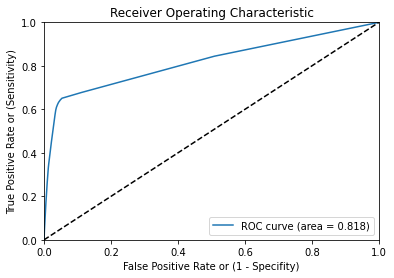

In [770]:
plt.plot(fpr_gbc, tpr_gbc, label=f'ROC curve (area = {round(roc_auc_gbc, 3)})')
plt.plot([0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [774]:
print(f"GradientBoostingClassifierArea Under Curve of Receiver Operating Characteristic: \
{round(roc_auc_score(y_test, pred_proba_gbc[:,1]), 3)}")

GradientBoostingClassifierArea Under Curve of Receiver Operating Characteristic: 0.818


#### Feature importance calculation

In [775]:
gbc_importance = gbc.feature_importances_
indices_gbc = np.argsort(gbc_importance)

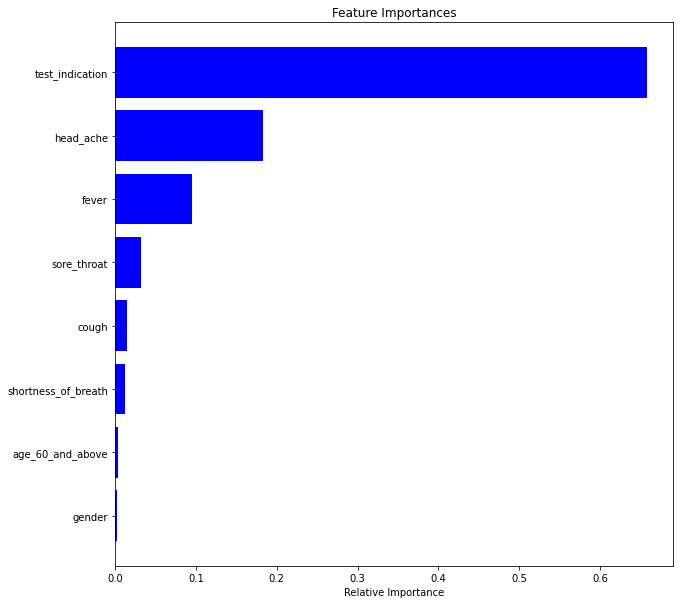

In [776]:
plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices_gbc)), gbc_importance[indices_gbc], color='b', align='center')
plt.yticks(range(len(indices_gbc)), [features[i] for i in indices_gbc])
plt.xlabel('Relative Importance')
plt.show()

In [777]:
for i,v in enumerate(gbc_importance):
    print(f'Feature: {feature_names[i]}, Score: {round(v, 5)}')

Feature: cough, Score: 0.01452
Feature: fever, Score: 0.09568
Feature: sore_throat, Score: 0.03174
Feature: shortness_of_breath, Score: 0.01247
Feature: head_ache, Score: 0.18251
Feature: age_60_and_above, Score: 0.00374
Feature: gender, Score: 0.00181
Feature: test_indication, Score: 0.65753
